# **NLP Multi-Class Classification**

-------
### Imports

In [357]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer

from sklearn.metrics import plot_confusion_matrix, classification_report

-------
## Joining the Reviews and Listings Datasets

In [330]:
listings = pd.read_csv('../data/listings_cleaned.csv')

In [331]:
listings.head(2)

,id,last_scraped,name,description,host_id,host_name,host_since,host_response_time,host_response_rate,host_is_superhost,...,reviews_per_month,city,state,zip_codes,bathrooms,bathrooms_shared,amenities_count,host_verifications_count,private_listing,rating_target
0,3781,2021-09-19,HARBORSIDE-Walk to subway,Fully separate apartment in a two apartment bu...,4804,Frank,2008-12-03,3,100.0,0,...,0.29,Boston,Massachusetts,2128,1.0,0,31,3,1,3
1,5506,2021-09-19,** Private! Minutes to center!**,"Private guest room with private bath, You do n...",8229,Terry,2009-02-19,3,100.0,1,...,0.90,Boston,Massachusetts,2119,1.0,0,30,4,1,2


In [332]:
reviews = pd.read_csv('../data/reviews_cleaned.csv', low_memory=False)

In [333]:
reviews.head(2)

,listing_id,review_id,date,reviewer_id,reviewer_name,comments,lower_comments
0,3781,37776825,2015-07-10,36059247.0,Greg,The apartment was as advertised and Frank was ...,the apartment was as advertised and frank was ...
1,3781,41842494,2015-08-09,10459388.0,Tai,It was a pleasure to stay at Frank's place. Th...,it was a pleasure to stay at frank's place. th...


In [334]:
print(listings['id'].dtype)
print(reviews['listing_id'].dtype)

int64
object


-----
## Setting up the Target Column

In [335]:
reviews[reviews['listing_id'] == '<br/>june and john from barry south wales']

,listing_id,review_id,date,reviewer_id,reviewer_name,comments,lower_comments
35,<br/>june and john from barry south wales,the only reason i have not given 5stars is alt...,NaN,NaN,NaN,NaN,NaN
36,<br/>june and john from barry south wales,NaN,NaN,NaN,NaN,NaN,NaN


In [336]:
reviews[reviews['listing_id'] == '<br/>']

,listing_id,review_id,date,reviewer_id,reviewer_name,comments,lower_comments
44,<br/>,NaN,NaN,NaN,NaN,NaN,NaN
46,<br/>,NaN,NaN,NaN,NaN,NaN,NaN
62,<br/>,NaN,NaN,NaN,NaN,NaN,NaN
65,<br/>,+ the room is wonderful and very clean,NaN,NaN,NaN,NaN,NaN
71,<br/>,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
100919,<br/>,NaN,NaN,NaN,NaN,NaN,NaN
101621,<br/>,philip was great! he helped us from the arriva...,NaN,NaN,NaN,NaN,NaN
101622,<br/>,NaN,NaN,NaN,NaN,NaN,NaN
102123,<br/>,NaN,NaN,NaN,NaN,NaN,NaN


In [337]:
reviews[reviews['listing_id'] == '<br/>Enjoy.']

,listing_id,review_id,date,reviewer_id,reviewer_name,comments,lower_comments
45,<br/>Enjoy.,this is really a great location. the street is...,NaN,NaN,NaN,NaN,NaN


In [338]:
reviews[reviews['listing_id'] == '<br/>enjoy.']

,listing_id,review_id,date,reviewer_id,reviewer_name,comments,lower_comments
47,<br/>enjoy.,NaN,NaN,NaN,NaN,NaN,NaN


In [339]:
reviews[reviews['listing_id'] == '<br/>+ bathroom very nice and fully equipped']

,listing_id,review_id,date,reviewer_id,reviewer_name,comments,lower_comments
57,<br/>+ bathroom very nice and fully equipped,NaN,NaN,NaN,NaN,NaN,NaN
66,<br/>+ bathroom very nice and fully equipped,NaN,NaN,NaN,NaN,NaN,NaN


In [340]:
print(f'listings shape: {listings.shape}')
print(f'reviews shape: {reviews.shape}')

listings shape: (10664, 55)
reviews shape: (232218, 7)


In [341]:
reviews['lower_comments'].isnull().sum()

4727

In [342]:
reviews.isnull().sum()

listing_id           0
review_id         3045
date              3874
reviewer_id       3874
reviewer_name     3875
comments          3889
lower_comments    4727
dtype: int64

In [343]:
# filtering out any columns with letters for listing id
reviews[reviews['listing_id'].str.contains('[A-Za-z]') == True]

,listing_id,review_id,date,reviewer_id,reviewer_name,comments,lower_comments
35,<br/>june and john from barry south wales,the only reason i have not given 5stars is alt...,NaN,NaN,NaN,NaN,NaN
36,<br/>june and john from barry south wales,NaN,NaN,NaN,NaN,NaN,NaN
44,<br/>,NaN,NaN,NaN,NaN,NaN,NaN
45,<br/>Enjoy.,this is really a great location. the street is...,NaN,NaN,NaN,NaN,NaN
46,<br/>,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
102131,<br/>close to everything. uncomplicated.,NaN,NaN,NaN,NaN,NaN,NaN
103350,<br/>Everything was very convenient and enjoya...,john and allie are very nice and responsible h...,NaN,NaN,NaN,NaN,NaN
103351,<br/>everything was very convenient and enjoya...,NaN,NaN,NaN,NaN,NaN,NaN
112335,<br/>For others who might end up booking this ...,ann made us feel very (website hidden by airbn...,NaN,NaN,NaN,NaN,NaN


In [344]:
# ~3,800 rows (out of ~230,000 total) with incorrect listing id and null column values
# drop these from the data frame
# the below code was adapted from jezrael's response on stack overflow at https://stackoverflow.com/questions/50134687/filter-all-rows-that-do-not-contain-letters-alpha-in-%C2%B4pandas%C2%B4 ()
reviews = reviews[reviews['listing_id'].str.contains('[A-Za-z]') == False].copy()

In [345]:
print(reviews.isnull().sum())

listing_id          0
review_id           0
date                0
reviewer_id         0
reviewer_name       1
comments           15
lower_comments    853
dtype: int64


In [346]:
# dropping remaining nulls in the cleaned comments column 
# and in the rating targets column
reviews.dropna(subset= 'lower_comments', inplace = True)
reviews.isnull().sum()

listing_id        0
review_id         0
date              0
reviewer_id       0
reviewer_name     1
comments          0
lower_comments    0
dtype: int64

In [347]:
listings['rating_target'].isnull().sum()

0

In [348]:
# ensure the columns to merge on are of the same data type
reviews['listing_id'] = reviews['listing_id'].astype(int)

In [349]:
# merge the two dataframes
df = pd.merge(left = listings, right = reviews, left_on= 'id', right_on= 'listing_id', )
df.shape

(628691, 62)

In [350]:
# make sure to not get any of the same reviews that happened to be pulled at a later date
df.drop_duplicates(['review_id'], inplace=True)

In [351]:
df.shape

(226530, 62)

In [352]:
df.to_csv('../data/merged.csv', index=False)

------
# **NLP Modeling of the Reviews**

#### *Start with Naive Bayes - including default hyper paramaters (and small number of features)*

In [354]:
# define X and y
X = df['lower_comments']
y = df['rating_target']

# determining a baseline accuracy
print(y.value_counts())
print('*'*45)
print(y.value_counts(normalize=True))
print('*'*45)

print(f'Baseline Accuracy: {round(pd.Series(y.value_counts(normalize=True))[3]*100, 2)}%')


3    94690
2    68969
1    33697
4    29174
Name: rating_target, dtype: int64
*********************************************
3    0.418002
2    0.304459
1    0.148753
4    0.128786
Name: rating_target, dtype: float64
*********************************************
Baseline Accuracy: 41.8%


In [355]:
# train test split - stick with the default 75/25 split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                     stratify= y,
                                                    random_state= 42)

In [392]:
def build_pipeline(num_features, model_abbrev, instance, X_train, y_train, X_test, y_test ):
    '''
    This function builds a pipeline
    instantiates and fits the model 
    and generates a confusion matrix
    '''
    pipe = Pipeline([
        ('cvec', CountVectorizer(max_features = num_features)),
        (model_abbrev, instance)
    ])

    pipe.fit(X_train, y_train)
    print('Train:', pipe.score(X_train, y_train))
    print('Test:', pipe.score(X_test, y_test))

    return plot_confusion_matrix(pipe, X_test, y_test, cmap = 'Reds');

# CVEC and NAIVE Bayes

Train: 0.4189244071407971
Test: 0.417442127381562


/Users/petermurphy/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


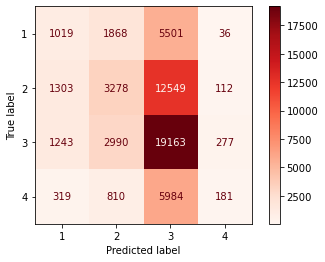

In [393]:
# try same number of features from EDA
build_pipeline(50, 'nb', MultinomialNB(), X_train, y_train, X_test, y_test)

Train: 0.5779148542940723
Test: 0.5416453304610386


/Users/petermurphy/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


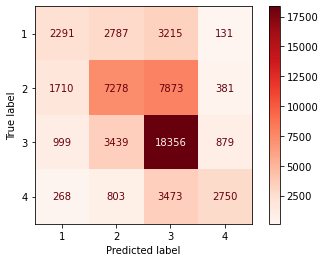

In [394]:
# check with results with many more features
build_pipeline(220000, 'nb', MultinomialNB(), X_train, y_train, X_test, y_test)

# CVEC and Logistic Regression

Train: 0.4342572264371943
Test: 0.43365175780905124


/Users/petermurphy/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


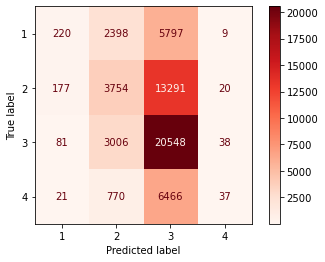

In [408]:
build_pipeline(50, 'logreg', LogisticRegression(max_iter = 200), X_train, y_train, X_test, y_test)

/Users/petermurphy/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train: 0.6179567620381761
Test: 0.5648473504846997


/Users/petermurphy/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


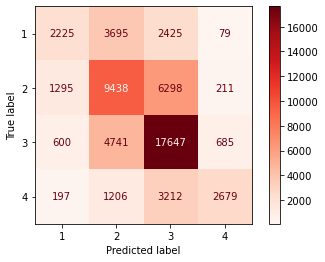

In [407]:
build_pipeline(220000, 'logreg', LogisticRegression(max_iter=200), X_train, y_train, X_test, y_test)

# CVEC and Random Forest

### Grid searching